Implementation of 2D finite difference, solve the equation using weighted Jacobi iteration method.

Construct the linear equation system Ax = b for a 2D Poisson problem:
            - u_xx - u_yy = f(x,y), -1 < x,y < 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class GridFD():
    '''
    Note: the n should be the number of intervals, e.g., 
    there are (n+1)*(n+1) grid points if the size is n
    '''
    def __init__(self, n, rhs = None):
        self.n = n
        self.v = np.zeros((n+1)*(n+1))
        if (rhs is None):
            self.f = np.zeros((n+1)*(n+1))
        else:
            self.f = np.copy(rhs)        
        self.A = self.CreateA()
        
    def CreateA(self):
        '''
        Construct the matrix based on row-index first rule, assume a square domain: hx = hy = h
        ''' 
        h = 2.0/self.n
        stencil = np.array([-1.0/h/h, 4.0/h/h, -1.0/h/h])
        B_temp = np.zeros((self.n+3,self.n+3))
        for i in range(1,self.n+2):
            B_temp[i,i-1:i+2] = stencil
        B = B_temp[1:self.n+2,1:self.n+2] # size is (n+1)x(n+1)
        A = np.kron(np.eye(self.n+1),B) # diagonal of the stiffness matrix

        Eye_side_block = -1./h/h*np.eye(self.n+1) # size is (n+1)x(n+1)
        A = A + np.kron(np.diag(np.ones(self.n),1),Eye_side_block)
        A = A + np.kron(np.diag(np.ones(self.n),-1),Eye_side_block)
        return A

    def SetDirichletBC(self, bc_index, bc_value):
        '''
        bc_index: non-zero if Dirichlet bc is applied, otherwise 0
        bc_value: value of boundary grid points, size is the same as bc_index
        '''

        bcs = np.where(bc_index > 0)

        # modify stiffness matrix
        self.A[bcs,:] = 0.0
        self.A[bcs,bcs] = 1.0

        # modify rhs
        self.f[bcs] = bc_value[bcs]

    def Relax(self, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iterations for current level of grid
        '''
        omega = 2/3.
        Dinv = np.diag(1.0/np.diag(self.A))
        v = self.v
        for i in range(num_sweeps_down):
            vprev = v
            residual = self.f - np.dot(self.A,vprev)
            v = omega*np.dot(Dinv,residual) + vprev
        return v

In [3]:
# Problem parameters
n = 2**5

k = 0.5
l = 1

x = np.linspace(-1,1,n+1)
y = np.linspace(-1,1,n+1)
xx, yy = np.meshgrid(x, y, indexing='ij')

#rhs = np.sin(k*np.pi*xx)*np.cos(l*np.pi*yy)  
rhs = np.ones_like(xx)
prob = GridFD(n, rhs.flatten())

In [4]:
# construct boundary points
# indices follow the pattern: 0,0; 0,1; 0,2; ...; 0,n; 1,0; 1,1; ...; n,n 
bc_index = np.zeros(((n+1),(n+1)))
bc_index[:,0] = 1 # assign values at y = -1
bc_index[:,-1] = 2 # assign values at y = 1
bc_index[-1,:] = 3 # assign values at x = 1
bc_index[0,:] = 4 # assign values at x = -1
bc_index = bc_index.flatten()

bc_value = np.zeros((n+1)*(n+1))
bc_value[np.where(bc_index == 4)] = 0.0

# set boundary condition
prob.SetDirichletBC(bc_index, bc_value)

In [5]:
EPS = 1e-6
n_jacobi = 0
u_jacobi = np.zeros((n+1)*(n+1))
u_jacobi[np.where(bc_index == 4)] = 1
res = np.linalg.norm(prob.f - np.dot(prob.A,u_jacobi))
res_jacobi = [res]
while (res>EPS):
    prob.v = u_jacobi
    u_jacobi = prob.Relax(1)
    res = np.linalg.norm(prob.f - np.dot(prob.A,u_jacobi))
    res_jacobi.append(res)
    n_jacobi += 1
    print(n_jacobi, res)

print("Solution converges after ", n_jacobi, "Weighted Jacobi iterations")

1 252.00154320515134
2 328.24238729148743
3 278.88591312169734
4 206.4278516009199
5 150.37229974516012
6 112.34247413771801
7 87.16363326146994
8 70.28893818859781
9 58.70883856370942
10 50.562039105338954
11 44.70001503954955
12 40.39817837040788
13 37.18593518626409
14 34.74901151423679
15 32.87247813216597
16 31.406474205752037
17 30.24485032333486
18 29.311421135362533
19 28.550873820088384
20 27.92262675997413
21 27.3966123311254
22 26.950342829113
23 26.56684664808997
24 26.23320247429285
25 25.939488849273296
26 25.678024944180763
27 25.442817251658568
28 25.229153072192638
29 25.033299476682995
30 24.852278646002578
31 24.683698939289425
32 24.525626930659346
33 24.37648978560319
34 24.235000267944695
35 24.100098745871847
36 23.970908054333602
37 23.846698145281824
38 23.72685823758248
39 23.61087474911245
40 23.49831371368162
41 23.388806696697664
42 23.282039455579024
43 23.17774276502933
44 23.075684958680167
45 22.975665838343563
46 22.87751167824549
47 22.78107111004127


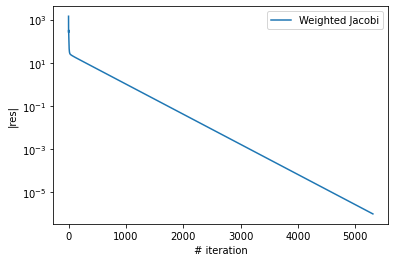

In [6]:
# Plot the residual evolution
plt.plot(res_jacobi, label='Weighted Jacobi')
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('# iteration')
plt.ylabel('|res|')
plt.legend()

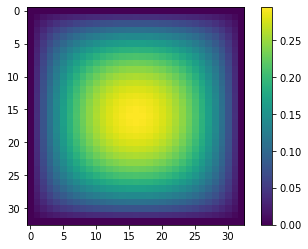

In [7]:
'''Plot the solution vector v in 2D'''
solution = prob.v
uu = solution.reshape(xx.shape)
plt.imshow(uu)
plt.colorbar()